# GPU

##Libraries

In [ ]:
import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt  # <-- for plotting

from collections import deque
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Asymmetric Polarization
!pwd

# ----------------------
# Check Device
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Mounted at /content/drive
/content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Asymmetric Polarization
/content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Asymmetric Polarization
Using device: cuda


##Enviroment

**Limited action**

In [ ]:
# ----------------------
# 1) Modified Environment with 9 Discrete Actions
# ----------------------
class OpinionEnv9Actions:
    """
    A vectorized environment with exactly 9 discrete actions for each "player" (row & column).
    Each action maps to M/2 Bernoulli bits using 'probabilities' and 'deltas', then we concatenate
    row & column to form an M-dimensional 'action' for the media update.

    The adjacency factor for media is:
        fac = (1 + eta * action) * (1 + eta2 * (2 - c - action)*(1 - s))

    Credibility is updated with: c = gamma * c + (1 - gamma)*action
    The observation is a histogram of x plus the current credibility c.
    """

    def __init__(self,
                 num_envs=32,
                 N=500,
                 M=10,
                 terminal_time=200,
                 bM=4,
                 b=18,
                 noise_level=0.1,
                 h=0.1,
                 nbins=30,
                 r_scale=100,
                 eta=1,
                 eta2=2,
                 beta_1=3,
                 beta_2=2,
                 lambda_c=0.98):
        """
        :param num_envs:       Number of parallel envs
        :param N:              Number of agents
        :param M:              Media dimension
        :param terminal_time:  Steps until done
        :param bM, b:          Coupling constants for media and social
        :param noise_level:    Std dev of noise
        :param h:              Euler step size
        :param nbins:          Number of histogram bins
        :param r_scale:        Scale factor for rewards
        :param eta, eta2:      Multipliers in the adjacency factor
        :param beta_1, beta_2: Beta distribution parameters for susceptibility
        :param gamma:          Credibility discount factor
        """
        self.num_envs = num_envs
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        self.bM = bM
        self.b = b
        self.noise_level = noise_level
        self.h = torch.tensor(h, device=device, dtype=torch.float32)
        self.nbins = nbins
        self.r_scale = r_scale
        self.eta = eta
        self.eta2 = eta2
        self.lambda_c = lambda_c
        self.pi = torch.tensor(math.pi, device=device)

        # Beta distribution for s
        BetaDist = torch.distributions.beta.Beta(beta_1, beta_2)

        # Shared across all envs: media positions in [-1,1], shape [M]
        self.ym = torch.linspace(-1, 1, steps=self.M, device=device)

        # Environment states: x, c, t, s
        # x: shape [num_envs, N]
        # c: shape [num_envs, M]
        # t: shape [num_envs]
        # s: shape [num_envs, N] (from BetaDist)
        self.x = torch.zeros(self.num_envs, self.N, device=device)
        self.c = torch.zeros(self.num_envs, self.M, device=device)
        self.t = torch.zeros(self.num_envs, device=device)
        self.s = BetaDist.sample(sample_shape=(self.num_envs, self.N)).to(device)
        self.AEm=torch.zeros((self.num_envs,self.N,self.M),device=device)

        # Exactly 9 actions
        self.action_dim = 9

        # Prob & delta for each of the 9 discrete actions
        self.probabilities = torch.tensor(
            [0.95, 0.95, 0.95, 0.50, 0.50, 0.10, 0.10, 0.50, 0.10],
            device=device
        )
        self.deltas = torch.tensor(
            [0.000001, 0.85, 0.45, -0.00001, -0.45, -0.85, -0.0000001, 0.4, -0.4],
            device=device
        )
        # For the M/2 dimension
        self.zm = torch.linspace(0, 1, steps=self.M // 2, device=device)

        # Init
        self.reset()

    def reset(self):
        """
        Reset all envs to initial state.
        """
        with torch.no_grad():
            # x in [-1,1]
            BetaDist = torch.distributions.beta.Beta(1.5,2)
            temp_x= BetaDist.sample(sample_shape=(self.num_envs, self.N)).to(device)
            self.x=2*temp_x-1
            # c=1
            self.c.fill_(1.0)
            # t=0
            self.t.zero_()
            # If you want to re-sample s here, uncomment:
            BetaDist = torch.distributions.beta.Beta(3,2)
            self.s = BetaDist.sample(sample_shape=(self.num_envs, self.N)).to(device)
        return self.state2obs()

    def state2obs(self):
        """
        Observation shape [num_envs, nbins + M] = [hist(x), c].
        """
        obs_list = []
        for i in range(self.num_envs):
            # histogram of x[i] with nbins in [-1,1], normalized
            hist_i = torch.histc(self.x[i], bins=self.nbins, min=-1, max=1)
            hist_i = hist_i / self.N
            # c[i]: shape [M]
            obs_list.append(torch.cat([hist_i, self.c[i]]))
        # stack => shape [num_envs, nbins+M]
        obs = torch.stack(obs_list, dim=0)
        return obs

    def _convert_action_ids_to_vec(self, action_ids):
        """
        Convert each action_id in {0..8} to an M/2 Bernoulli vector.
        final_prob = base_prob - zm * delta_prob
        Then sample Bernoulli( final_prob ).
        Returns shape [num_envs, M//2].
        """
        base_probs = self.probabilities[action_ids]  # [num_envs]
        delta_probs = self.deltas[action_ids]        # [num_envs]

        # final_prob[i,j] = base_probs[i] - (zm[j]*delta_probs[i])
        final_prob = base_probs.unsqueeze(1) - self.zm.unsqueeze(0)*delta_probs.unsqueeze(1)
        final_prob = final_prob.clamp(min=0.0, max=1.0)
        action_vec = torch.bernoulli(final_prob)
        return action_vec  # [num_envs, M//2]

    def step(self, action_pl_ids, action_op_ids):
        """
        Step the environment by 1 Euler iteration using row/column action IDs in {0..8}.
        Returns next_obs, rewards, done, info.
        """
        with torch.no_grad():
            # Build row & column actions => [num_envs, M//2]
            row_act = self._convert_action_ids_to_vec(action_pl_ids)
            col_act = self._convert_action_ids_to_vec(action_op_ids)
            # Combine => [num_envs, M]
            action = torch.cat([row_act, col_act], dim=1)

            # Distances
            DM = self.ym.view(1,1,-1) - self.x.unsqueeze(2)  # [num_envs,N,M]
            xx = self.x.unsqueeze(2)
            D = xx - xx.transpose(1,2)                      # [num_envs,N,N]

            # Media adjacency factor:
            # fac = (1 + eta*action) * (1 + eta2*(2-c-action)*(1-s))
            # We'll do shape expansions:
            #   action => [num_envs,M] => unsqueeze(1)->[num_envs,1,M]
              # (2-c-action) => same shape => unsqueeze(1)->[num_envs,1,M]
            #   (1-s) => [num_envs,N] => unsqueeze(2)->[num_envs,N,1]
            fac = (1.0 + self.eta*action).unsqueeze(1) * (
                1.0 + self.eta2*(2.0 - self.c - action).unsqueeze(1)*(1.0 - self.s).unsqueeze(2)
            )

            AM = torch.exp(-self.bM * fac * torch.abs(DM))  # [num_envs,N,M]
            A = torch.exp(-self.b * torch.abs(D))           # [num_envs,N,N]
            self.AEm += torch.exp(-self.bM * torch.abs(DM))* (1-action.unsqueeze(1))
            self.media_attention=AM
            # Credibility update => c = gamma*c + (1-gamma)*action
            self.c = self.c*self.lambda_c + action*(1-self.lambda_c)

            # Weighted updates for x D has sign in it
            x_update_social = -(A * D).sum(dim=2)/A.sum(dim=2).clamp_min(1e-12)
            x_update_media = (AM * DM).sum(dim=2)/AM.sum(dim=2).clamp_min(1e-12)

            # Noise
            noise = torch.normal(
                mean=0.0, std=self.noise_level,
                size=(self.num_envs, self.N),
                device=device
            )


            # Euler update
            self.x = self.x + self.h*(x_update_social + x_update_media) + torch.sqrt(self.h)*noise

            # time
            self.t += 1

            # Reward => r_scale * -avg( sin^5(pi*x/2) )
            sin_val = torch.sin((self.pi/2.0)*self.x)
            sin_pow5 = sin_val.pow(5)
            mean_sin_pow5 = sin_pow5.mean(dim=1)  # [num_envs]
            rewards = self.r_scale * (-mean_sin_pow5)

            # Done?
            done = (self.t >= self.terminal_time)

        next_obs = self.state2obs()
        return next_obs, rewards, done, {}

##Training Modules

In [ ]:


# ----------------------
# 2) GPU-based Replay Buffer
# ----------------------
class GPUReplayBuffer:
    """
    Stores transitions on GPU to reduce CPU-GPU overhead.
    """
    def __init__(self, capacity, obs_dim):
        self.capacity = capacity
        self.obs_dim = obs_dim
        self.index = 0
        self.size = 0

        # Pre-allocate on GPU
        self.obs_buf      = torch.zeros((capacity, obs_dim),    device=device)
        self.next_obs_buf = torch.zeros((capacity, obs_dim),    device=device)
        self.actions_pl   = torch.zeros((capacity,), dtype=torch.long, device=device)
        self.actions_op   = torch.zeros((capacity,), dtype=torch.long, device=device)
        self.rewards      = torch.zeros((capacity,), device=device)
        self.dones        = torch.zeros((capacity,), device=device)

    def store(self, obs, action_pl, action_op, reward, next_obs, done):
        """
        obs, next_obs: shape [num_envs, obs_dim]
        action_pl, action_op, reward, done: shape [num_envs]
        We'll flatten into one big buffer (just store row by row).
        """
        batch_size = obs.shape[0]
        end_idx = self.index + batch_size

        if end_idx <= self.capacity:
            idx_range = torch.arange(self.index, end_idx, device=device)
        else:
            # wrap around
            remainder = end_idx - self.capacity
            idx_range1 = torch.arange(self.index, self.capacity, device=device)
            idx_range2 = torch.arange(0, remainder, device=device)
            idx_range = torch.cat([idx_range1, idx_range2], dim=0)

        # Write to buffer
        self.obs_buf[idx_range]      = obs
        self.actions_pl[idx_range]   = action_pl
        self.actions_op[idx_range]   = action_op
        self.rewards[idx_range]      = reward
        self.next_obs_buf[idx_range] = next_obs
        self.dones[idx_range]        = done

        # Update pointer
        self.index = (self.index + batch_size) % self.capacity
        self.size  = min(self.size + batch_size, self.capacity)

    def sample(self, batch_size):
        idxs = np.random.randint(0, self.size, size=batch_size)
        idxs_t = torch.from_numpy(idxs).to(device)

        obs       = self.obs_buf[idxs_t]
        a_pl      = self.actions_pl[idxs_t]
        a_op      = self.actions_op[idxs_t]
        rewards   = self.rewards[idxs_t]
        next_obs  = self.next_obs_buf[idxs_t]
        dones     = self.dones[idxs_t]
        return obs, a_pl, a_op, rewards, next_obs, dones


# ----------------------
# 3) Soft Q-Network (Same but with action_dim=9 => output=81)
# ----------------------
class SoftQNet(nn.Module):
    """
    The network estimates Q(s, (a_pl, a_op)) => output shape [batch, action_dim^2].
    We then factorize using getQ_pl, getQ_op, etc.
    """
    def __init__(self, observation_dim, bpl=5.0, bop=-5.0, action_dim=9):
        super(SoftQNet, self).__init__()
        self.observation_dim = observation_dim
        self.bpl = bpl
        self.bop = bop
        self.action_dim = action_dim

        # Precompute indexing for row/col factorization
        # e.g. if action_dim=9, we get 9x9=81
        # makspl[i, :] => indexes in [0..81) corresponding to row i
        # maksop[i, :] => indexes in [0..81) corresponding to column i
        self.makspl = torch.zeros(action_dim, action_dim, dtype=torch.long)
        self.maksop = torch.zeros(action_dim, action_dim, dtype=torch.long)
        idxs = torch.arange(action_dim, dtype=torch.long)
        for i in range(action_dim):
            self.makspl[i, :] = i * action_dim + idxs
            self.maksop[i, :] = action_dim * idxs + i
        self.makspl = self.makspl.to(device)
        self.maksop = self.maksop.to(device)

        hidden1 = 128
        hidden2 = 128
        hidden3 = 128
        hidden4 = 128

        # Deeper MLP
        self.fc1 = nn.Linear(self.observation_dim, hidden1)
        self.ln1 = nn.LayerNorm(hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.ln2 = nn.LayerNorm(hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.ln3 = nn.LayerNorm(hidden3)
        self.fc4 = nn.Linear(hidden3, hidden4)
        self.ln4 = nn.LayerNorm(hidden4)
        self.out = nn.Linear(hidden4, action_dim**2)  # => 81 if action_dim=9

    def forward(self, obs):
        x = F.relu((self.fc1(obs)))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc4(x)
        q = self.out(x)  # [batch_size, action_dim^2]
        return q

    @staticmethod
    def log_sum_exp(x):
        # Numerically stable log-sum-exp along dim=1
        max_x, _ = x.max(dim=1, keepdim=True)
        exps = torch.exp(x - max_x)
        sum_of_exps = exps.sum(dim=1)
        return torch.log(sum_of_exps) + max_x.squeeze(dim=1)

    def getQ_pl(self, q_value):
        """
        For each row-action i, do log-sum-exp over column actions * bop => Q_pl(s, i).
        """
        batch_size = q_value.shape[0]
        Qa = torch.zeros((batch_size, self.action_dim), device=device)
        for i in range(self.action_dim):
            x = self.bop * q_value[:, self.makspl[i, :]]  # shape [batch, action_dim]
            # (1/bop)*[log_sum_exp( bop * Q(s,a) ) - log(action_dim)]
            Qa[:, i] = (1.0/self.bop)*(self.log_sum_exp(x) - math.log(self.action_dim))
        return Qa

    def getQ_op(self, q_value):
        """
        For each column-action i, do log-sum-exp over row actions * bpl => Q_op(s, i).
        """
        batch_size = q_value.shape[0]
        Qa = torch.zeros((batch_size, self.action_dim), device=device)
        for i in range(self.action_dim):
            x = self.bpl * q_value[:, self.maksop[i, :]]  # shape [batch, action_dim]
            Qa[:, i] = (1.0/self.bpl)*(self.log_sum_exp(x) - math.log(self.action_dim))
        return Qa

    def getV(self, q_value):
        """
        V(s) = (1/bpl)* [ logsumexp( bpl * Q_pl(s,a) ) - log(action_dim) ]
        using Q_pl derived from q_value.
        """
        Q_pl = self.getQ_pl(q_value)  # [batch, action_dim]
        v = (1.0 / self.bpl)* (self.log_sum_exp(self.bpl * Q_pl) - math.log(self.action_dim))
        return v

    def batch_act(self, obs, epsilon=0.1):
        """
        Sample row & column actions from softmax distributions => [num_envs] each.
        Epsilon-greedy.
        """
        with torch.no_grad():
            q_value = self.forward(obs)  # [num_envs, action_dim^2]
            Q_pl = self.getQ_pl(q_value) # [num_envs, action_dim]
            Q_op = self.getQ_op(q_value) # [num_envs, action_dim]

            pi_pl = F.softmax(self.bpl * Q_pl, dim=-1)
            pi_op = F.softmax(self.bop * Q_op, dim=-1)

            # Epsilon-greedy for row
            rand_vals = torch.rand(obs.shape[0], device=device)
            pl_actions = torch.empty(obs.shape[0], dtype=torch.long, device=device)
            mask_random_pl = rand_vals < epsilon
            pl_actions[mask_random_pl] = torch.randint(0, self.action_dim, (mask_random_pl.sum(),), device=device)
            dist_pl = torch.distributions.Categorical(pi_pl)
            pl_actions[~mask_random_pl] = dist_pl.sample()[~mask_random_pl]

            # Epsilon-greedy for column
            rand_vals = torch.rand(obs.shape[0], device=device)
            op_actions = torch.empty(obs.shape[0], dtype=torch.long, device=device)
            mask_random_op = rand_vals < epsilon
            op_actions[mask_random_op] = torch.randint(0, self.action_dim, (mask_random_op.sum(),), device=device)
            dist_op = torch.distributions.Categorical(pi_op)
            op_actions[~mask_random_op] = dist_op.sample()[~mask_random_op]

        return pl_actions, op_actions


# ----------------------
# 4) Soft Q Update
# ----------------------
def soft_q_update(replay_buffer, target_net, eval_net, gamma, optimizer, batch_size, tau=0.01):
    """
    One gradient update using a batch from the GPU replay buffer.
    """
    obs, a_pl, a_op, rewards, next_obs, dones = replay_buffer.sample(batch_size)

    # Current Q(s,a)
    q_values = eval_net(obs)  # [batch_size, action_dim^2]
    action_dim = eval_net.action_dim
    combined_index = a_pl * action_dim + a_op  # maps (row_action, col_action) => [0..action_dim^2)
    q_sa = q_values.gather(1, combined_index.unsqueeze(1)).squeeze(1)

    # Next state V(s')
    with torch.no_grad():
        q_values_next = target_net(next_obs)
        V_next = target_net.getV(q_values_next)  # [batch_size]
        target = rewards + gamma * (1.0 - dones) * V_next

    # MSE loss
    loss = F.mse_loss(q_sa, target)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(eval_net.parameters(), 1.0)
    optimizer.step()

    # Soft update
    with torch.no_grad():
        for tp, ep in zip(target_net.parameters(), eval_net.parameters()):
            tp.data.copy_(tau * ep.data + (1 - tau) * tp.data)

    return loss.item()



##Training

In [ ]:

# ----------------------
# 5) Main Training Loop
# ----------------------

# Hyperparameters
num_envs = 1000
N = 500
M = 10
gamma = 0.95
lambda_c=0.98
learning_rate = 1e-4
max_steps = 100 * num_envs * 200
train_start = 2000
train_freq = 100
batch_size = 128
capacity = 30 * num_envs * 200
bpl = 10.0
bop = -10.0
tau = 0.01
epsilon = 0.1
obs_dim = 30 + M  # nbins=30 + M=10 => 40
action_dim = 9    # exactly 9 discrete actions

# Create directories
os.makedirs("models_initial", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Create environment
env = OpinionEnv9Actions(
    num_envs=num_envs,
    N=N,
    M=M,
    terminal_time=200,
    bM=4,
    b=12,
    noise_level=0.12,
    h=0.1,
    nbins=30,
    r_scale=100,
    eta=1,
    eta2=1,
    beta_1=3,
    beta_2=2,
    lambda_c=0.98
)

# Create replay buffer on GPU
buffer = GPUReplayBuffer(capacity, obs_dim=obs_dim)

# Create networks
eval_net = SoftQNet(observation_dim=obs_dim, bpl=bpl, bop=bop, action_dim=action_dim).to(device)
target_net = SoftQNet(observation_dim=obs_dim, bpl=bpl, bop=bop, action_dim=action_dim).to(device)
target_net.load_state_dict(eval_net.state_dict())

optimizer = torch.optim.Adam(eval_net.parameters(), lr=learning_rate, weight_decay=1e-4)

# Initial reset
obs = env.reset()

step_count = 0
rewards_history = []
loss_history = []
update_count = 0
done_ctr = 0
loss_val = 0.0  # track last loss for printing

while step_count < max_steps:
    # Choose actions
    a_pl, a_op = eval_net.batch_act(obs, epsilon=epsilon)

    # Step environment
    next_obs, rewards, done, _ = env.step(a_pl, a_op)
    step_count += env.num_envs  # we advanced all envs

    # Store in replay
    buffer.store(obs, a_pl, a_op, rewards, next_obs, done.float())

    # Log average reward
    rewards_history.append(rewards.mean().item())

    # Move on
    obs = next_obs.clone()

    # Reset those envs that are done
    mask_done = (done == True)
    if mask_done.any():
        done_ctr += mask_done.sum().item()
        # Print some info
        avg_rew_recent = np.mean(rewards_history[-100:]) if len(rewards_history) > 100 else np.mean(rewards_history)
        print(f"Step: {step_count}, UpdateCount: {update_count}, Loss: {loss_val:.4f}, AvgReward(last100): {avg_rew_recent:.4f}")

        # Save checkpoint & some plots
        checkpoint_path = "models_initial/checkpoint_net.pth"
        torch.save(eval_net.state_dict(), checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

        # Plot rewards
        plt.figure(figsize=(8,6))
        plt.plot(rewards_history, label="Avg Reward per Step")
        plt.title(f"Average Reward up to Step {step_count}")
        plt.xlabel("Env Step")
        plt.ylabel("Average Reward")
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

        # Plot loss
        if len(loss_history) > 0:
            plt.figure(figsize=(8,6))
            plt.plot(loss_history, label="Loss")
            plt.title(f"Loss up to Step {step_count}")
            plt.xlabel("Update Count")
            plt.ylabel("MSE Loss")
            plt.legend()
            plt.tight_layout()
            plt.show()
            plt.close()

        # Plot average c
        curr_credibility = env.c.detach().cpu().numpy()   # [num_envs, M]
        avg_credibility = curr_credibility.mean(axis=0)
        plt.figure(figsize=(7,5))
        plt.scatter(np.linspace(-1,1,M), avg_credibility, alpha=0.7)
        plt.xlabel("Media Position")
        plt.ylabel("Avg Credibility")
        plt.title("Credibility vs. Media Position (After Some Env Done)")
        plt.tight_layout()
        plt.show()
        plt.close()

        # Reset those done envs
        new_obs = env.reset()
        obs[mask_done] = new_obs[mask_done]

    # Training
    if buffer.size > train_start:
        # do multiple gradient updates
        for _ in range(10):
            loss_val = soft_q_update(buffer, target_net, eval_net, gamma, optimizer, batch_size, tau)
            loss_history.append(loss_val)
            update_count += 1

# Post-training: Save final model
final_path = "models_initial/final_eval_net.pth"
torch.save(eval_net.state_dict(), final_path)
print(f"Training done. Final model saved at {final_path}")



Output hidden; open in https://colab.research.google.com to view.

##Test and plots

In [ ]:
import os
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scipy.stats as stats


# ----------------------
# Check Device
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Hyperparameters
num_envs = 100
N = 500
M = 10
gamma = 0.95
lambda_c=0.98
bpl = 10.0
bop = -10.0
obs_dim = 30 + M  # nbins=30 + M=10 => 40
action_dim = 9    # exactly 9 discrete actions

# Create directories
os.makedirs("models_initial", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Create environment
env = OpinionEnv9Actions(
    num_envs=num_envs,
    N=N,
    M=M,
    terminal_time=200,
    bM=4,
    b=12,
    noise_level=0.12,
    h=0.1,
    nbins=30,
    r_scale=100,
    eta=1,
    eta2=1,
    beta_1=3,
    beta_2=2,
    lambda_c=0.98
)






test_net = SoftQNet(observation_dim=obs_dim, bpl=bpl, bop=bop, action_dim=action_dim).to(device)
#########################################
#  1) LOAD the final trained model weights
#########################################
model_path = "models_initial/final_eval_net.pth"  # or use "checkpoint_epoch_1000.pth" etc.
# model_path = "models_limited_action/checkpoint_net.pth"
test_net.load_state_dict(torch.load(model_path, map_location=device))
test_net.eval()
# print(f"Loaded model from {model_path}")

#########################################
#  2) Run the testing (env.num_env episodes)
#########################################
obs = env.reset()
opinon_data=torch.zeros([env.num_envs,N,env.terminal_time],device=device)
with torch.no_grad():
    while True:
        # Choose actions for each env
        a_pl, a_op = test_net.batch_act(obs, epsilon=0.0)
        # Step environment
        next_obs, rewards, done, _ = env.step(a_pl, a_op)
        obs = next_obs.clone()
        mask_done = (done == True)
        if mask_done[0]:
          print("Done")
          break
        opinon_data[:,:,env.t[0].to(torch.int)]=env.x








Using device: cuda


<ipython-input-8-32d111f333c7>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_net.load_state_dict(torch.load(model_path, map_location=device))


Done


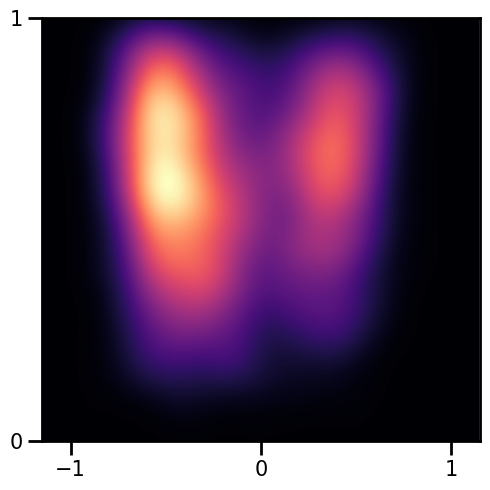

In [ ]:
#########################################
#  3) Plotting opinon-susceptibility distributions
#########################################

os.makedirs("plots_initial", exist_ok=True)
# Plot final average credibility
avg_credibility =  env.c.detach().cpu().numpy() .mean(axis=0)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
i_inv=np.random.randint(0,env.num_envs)
# sns.kdeplot(x=env.x[i_inv,:].detach().reshape(-1).cpu().numpy(), y=env.s[i_inv,:].detach().reshape(-1).cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=200, ax=ax)
sns.kdeplot(x=env.x[:10,:].detach().reshape(-1).cpu().numpy(), y=env.s[:10,:].detach().reshape(-1).cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=500, ax=ax)
ax.set_xlim(-1.15, 1.15)
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
plt.savefig('plots_initial/xs200-b10.svg')
plt.show()


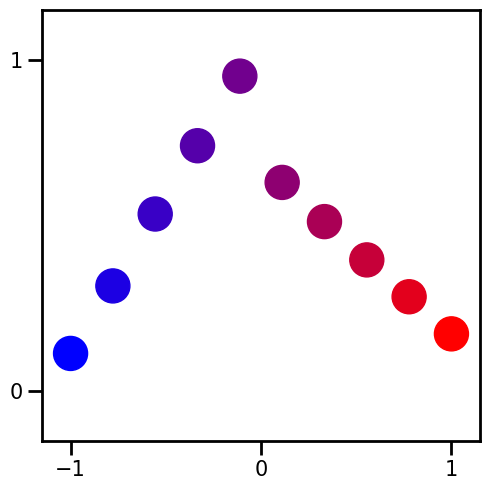

In [ ]:
#########################################
#  3) Plotting Equilibrium Distributions
#########################################
os.makedirs("plots_initial", exist_ok=True)
# Plot final average credibility
cmap = LinearSegmentedColormap.from_list("custom_blue_red", [(0, 0, 1), (1, 0, 0)], N=100)
fig, ax = plt.subplots(figsize=(5, 5))
avg_credibility =  env.c.detach().cpu().numpy().mean(axis=0)
ax.scatter(env.ym.cpu().numpy(), avg_credibility, s=600, c=env.ym.cpu().numpy(), cmap=cmap, alpha=1)
ax.set_xlim([-1.15, 1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
plt.savefig('plots_initial/xc200-10.svg')
plt.show()


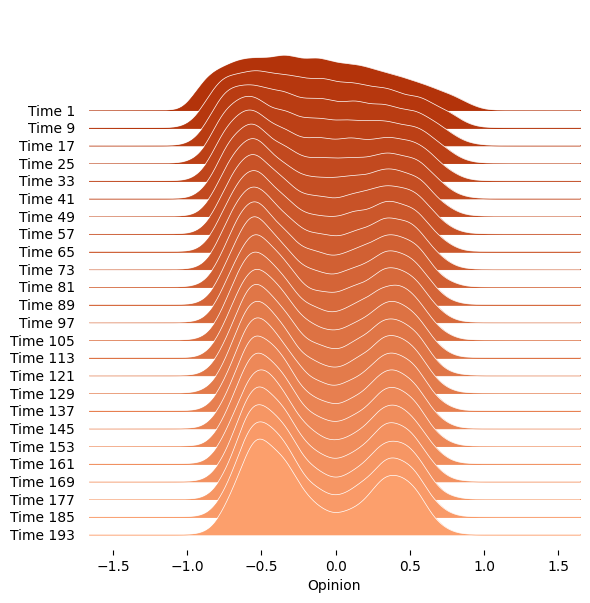

In [ ]:
!pip install joypy
from matplotlib import colormaps as cm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joypy
from scipy import stats

def color_gradient(x=0.0, start=(0, 0, 0), stop=(1, 1, 1)):
    r = np.interp(x, [0, 1], [start[0], stop[0]])
    g = np.interp(x, [0, 1], [start[1], stop[1]])
    b = np.interp(x, [0, 1], [start[2], stop[2]])
    return (r, g, b)

# Extract data
time_indices_to_plot = range(1, env.terminal_time, 8)
data_dict = {}

for idx, t in enumerate(time_indices_to_plot):
    data = opinon_data[:, :, t].reshape(-1).cpu().numpy()
    data_dict[f'Time {t}'] = data

# Convert to DataFrame
df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in data_dict.items()]))

# Ridge Plot using JoyPy
joypy.joyplot(df,
              figsize=(6, 6),
              overlap=1.5,
              colormap=lambda x: color_gradient(x, start=(.7, .2, .04), stop=(1.0, .64, .44)),
              linecolor='w', linewidth=.5)

plt.xlabel("Opinion")
plt.ylabel("Time Step")
plt.savefig('plots_initial/xt200-b10_joypy.svg')
plt.show()


<ipython-input-9-4cdf9cef5fbd>:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x>0].mean()/env.terminal_time


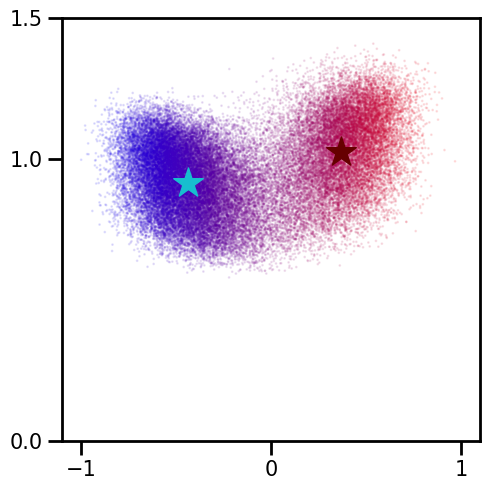

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
# Create the custom blue-red colormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red",[(0, 0, 1), (1, 0, 0)], N=100)
fig,ax=plt.subplots(figsize=(5,5))
env_rand=np.random.randint(0,env.num_envs)
x=env.x.squeeze().cpu().numpy().flatten()
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten().numpy()/(env.terminal_time-1),x=x,c=x,cmap=cmap,s=1,alpha=.1)
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x>0].mean()/env.terminal_time
           ,x=x[x>0].mean(),s=500,alpha=1,c=[.4,0,0],marker='*',linewidths=1)
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x<0].mean()/env.terminal_time
           ,x=x[x<0].mean(),s=500,alpha=1,c='tab:cyan',marker='*',linewidths=1)
# ax.scatter(y=env.AEm[env_rand,:,:].sum(axis=1).cpu().flatten().numpy()/(env.terminal_time-1),x=x,c=x,cmap=cmap,s=10,alpha=1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(0, 1.5)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0,1 ,1.5])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# ax.set_xlabel('Opinion',fontsize=15)
# ax.set_ylabel('Credibility',fontsize=15)
plt.tight_layout()
plt.savefig(f"plots_initial/Exposure.svg",dpi=300)
plt.show()
